In [1]:
import sys
if True:
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    root = "/content/drive/My Drive/Colab Notebooks/burgers/"
    sys.path.append("/content/drive/My Drive/Colab Notebooks/burgers/")
else:
    root = './'

Mounted at /content/drive


In [2]:
import numpy as np
import torch
from matplotlib import pylab as plt
if torch.cuda.device_count()>0:
    device = torch.device('cuda')
    print("Connected to a GPU")
else:
    print("Using the CPU")
    device = torch.device('cpu')

Connected to a GPU


In [ ]:
from util import *

In [ ]:
# TODO: test loss and validation loss

In [ ]:
loss = torch.nn.MSELoss()

In [ ]:
def train_it(dataset, model, Npast=1, Nfuture=1):
    #model = model
    learning_rate = 1e-4
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    Nepoch = 1000
    Nbatch = 100
    Ntotal = dataset.shape[0]*(dataset.shape[1]-(Npast+1)-Nfuture)
    Niter = Nepoch * Ntotal//Nbatch
    Nprint = (Niter)//10
    Nsave = 100
    losses = np.zeros((Niter//Nsave,2))
    
    for e in range(Niter):
        xx,yy = get_batch(Nbatch, dataset)
        y_pred = model(xx)+xx[:,:,1:-1]
        L = loss(y_pred,yy[:,:,1:-1])
        h = y_pred
        #for i in range(Nfuture-1):
            
        if e%Nprint == Nprint-1:
            print(e,L.item())
        if e%Nsave == Nsave-1:
            losses[e//Nsave,0] = L.item()
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
    return losses

In [43]:
for dataname in ["heat"]:
    data = np.load(root+f"data/{dataname}.npz")
    dataset = torch.tensor(data['U'],dtype=torch.float32,device=device)
    Ntraj,Nt,Nx = dataset.shape
    stash = {}
    for name, cls in models.items():
        print("Training ",name)
        model = cls(Nx).to(device)
        results = train_it(dataset,model)
        stash[name] = {'model':model,
                       'loss':results}

Training  PureStencil
469 0.08507096767425537
939 0.030807292088866234
1409 0.011036182753741741
1879 0.0033527084160596132
2349 0.0007909125415608287
2819 0.00014960745465941727
3289 0.0009229685529135168
3759 0.0002571622026152909
4229 0.00016342719027306885
4699 0.000516402767971158
Training  DeepStencil
469 0.0015051738591864705
939 0.00045967541518621147
1409 0.00017685742932371795
1879 0.0001384702482027933
2349 0.0003654127358458936
2819 0.0003104574279859662
3289 0.0010014834115281701
3759 0.0002613846736494452
4229 0.001662648399360478
4699 0.00017833813035394996
Training  FCMLP
469 1.9219651221646927e-05
939 4.90041020384524e-06
1409 1.5565581179544097e-06
1879 1.0324436061637243e-06
2349 7.527335696977389e-07
2819 5.78010372009885e-07
3289 4.939138307236135e-07
3759 3.1036722702992847e-07
4229 2.3063864773575915e-07
4699 4.6684681365150027e-07


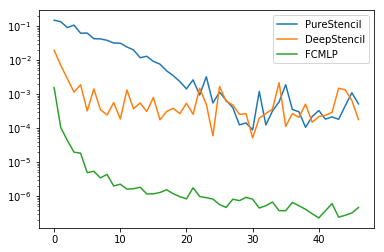

In [44]:
for N,S in stash.items():
    plt.semilogy(S['loss'][:,0],label=N)
plt.legend()

PureStencil


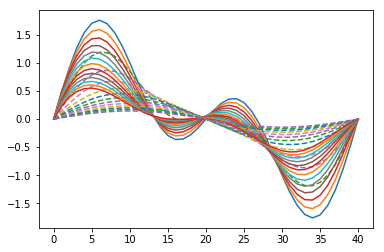

DeepStencil


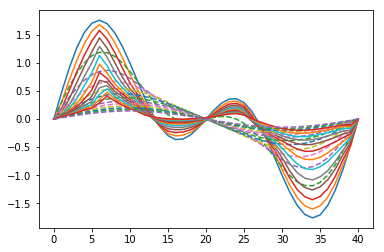

FCMLP


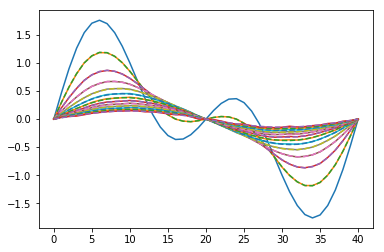

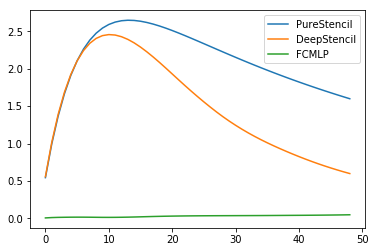

In [58]:
err = {}
for N,S in stash.items():
    print(N)
    err[N] = do_a_path(S['model'],dataset,5)
for N,e in err.items():
    plt.plot(e,label=N)
plt.legend()
plt.show()


In [46]:
list(stash["PureStencil"]['model'].parameters())

<generator object Module.parameters at 0x7f04c5416db0>

In [47]:
list(_)

[Parameter containing:
 tensor([[[ 0.1483, -0.3572,  0.1958]]], device='cuda:0', requires_grad=True)]

In [ ]:
import importlib
import util
importlib.reload(util)
from util import *

In [ ]:
import pickle

In [ ]:
outfile = open(root+'/db','wb')
torch.save(stash,outfile)
outfile.close()

In [52]:
stash

{'DeepStencil': {'loss': array([[1.95185523e-02, 0.00000000e+00],
         [7.03350967e-03, 0.00000000e+00],
         [2.84263701e-03, 0.00000000e+00],
         [1.14431384e-03, 0.00000000e+00],
         [1.88861345e-03, 0.00000000e+00],
         [3.21017375e-04, 0.00000000e+00],
         [1.42332143e-03, 0.00000000e+00],
         [3.50485439e-04, 0.00000000e+00],
         [2.43020360e-04, 0.00000000e+00],
         [5.64961869e-04, 0.00000000e+00],
         [1.85616052e-04, 0.00000000e+00],
         [1.32479786e-03, 0.00000000e+00],
         [3.70304449e-04, 0.00000000e+00],
         [5.49896387e-04, 0.00000000e+00],
         [3.08381888e-04, 0.00000000e+00],
         [7.96010660e-04, 0.00000000e+00],
         [1.75784808e-04, 0.00000000e+00],
         [3.09720577e-04, 0.00000000e+00],
         [3.81932012e-04, 0.00000000e+00],
         [2.66570278e-04, 0.00000000e+00],
         [5.38685767e-04, 0.00000000e+00],
         [2.54723360e-04, 0.00000000e+00],
         [1.48341840e-03, 0.000